# Written by Andrew Nell @andrewnell and Jon Kastelan #JKtours (jlk635)
# HW7 Assignment 1


In [1]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats


%pylab inline

if os.getenv ('PUI2016') is None:
    print ("Must set env variable PUI2017")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2017")

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define function for downloading file from internet and sending to PUIData
"""Function to download file from internet and save in PUIdata"""

def getbikedata(Datestr):
    
    os.system("curl -O https://s3.amazonaws.com/tripdata/" + Datestr + "-citibike-tripdata.zip")
    
    os.system("mv " + Datestr + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
    
    os.system("unzip " + os.getenv("PUIDATA") + "/" + Datestr + "-citibike-tripdata.zip -d " + os.getenv("PUIDATA")) 

# IDEA:
## Subscribers are less likely to travel for more than 45 minutes than customers
#### This is believed to be the case as citibike subscribers are allotted 45 minutes for a single trip (as part of their annual subscription) before additional charges are applied. Customers on the other hand are charged by 15 minute increments (with the first 30 minutes covered by daily fixed). 
##### (Incorporated feedback from reviewer mms911)

# NULL HYPOTHESIS:
## The proportion of subscribers who traveled over 45 minutes is the same as or greater than the proportion of customers who traveled over 45 minutes 
##### (Incorporated feedback from reviewer mms911)

# _$H_0$_ : $\frac{C_{\mathrm{Over 45}}}{C_{\mathrm{Total}}} <= \frac{S_{\mathrm{Over 45}}}{S_{\mathrm{Total}}}$
# _$H_1$_ : $\frac{C_{\mathrm{Over 45}}}{C_{\mathrm{total}}} > \frac{S_{\mathrm{Over 45}}}{S_{\mathrm{Total}}}$


## We use a significance level  $\alpha=0.05$

#### which means I want the probability of getting a result at least as significant as mine to be less then 5%

In [3]:
# Import data for specific date
Datestr = "201612"
getbikedata(Datestr) #Move file 201612 into PUIdata

In [4]:
# Read data and move into dataframe
CitibikeData = pd.read_csv(os.getenv("PUIDATA") + "/" + Datestr + "-citibike-tripdata.csv")

# Add columns for over/under 45 minutes
CitibikeData['Over45'] = CitibikeData['Trip Duration']> 45*60
CitibikeData['Over45'] = CitibikeData['Over45'].astype(int)
CitibikeData['Over45'] = CitibikeData['Over45'].replace(0,"Under 45")
CitibikeData['Over45'] = CitibikeData['Over45'].replace(1,"Over 45")

CitibikeData.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Over45
0,528,2016-12-01 00:00:04,2016-12-01 00:08:52,499,Broadway & W 60 St,40.769155,-73.981918,228,E 48 St & 3 Ave,40.754601,-73.971879,26931,Subscriber,1964.0,1,Under 45
1,218,2016-12-01 00:00:28,2016-12-01 00:04:06,3418,Plaza St West & Flatbush Ave,40.675021,-73.971115,3358,Garfield Pl & 8 Ave,40.671198,-73.974841,27122,Subscriber,1955.0,1,Under 45
2,399,2016-12-01 00:00:39,2016-12-01 00:07:19,297,E 15 St & 3 Ave,40.734232,-73.986923,345,W 13 St & 6 Ave,40.736494,-73.997044,19352,Subscriber,1985.0,1,Under 45
3,254,2016-12-01 00:00:44,2016-12-01 00:04:59,405,Washington St & Gansevoort St,40.739323,-74.008119,358,Christopher St & Greenwich St,40.732916,-74.007114,20015,Subscriber,1982.0,1,Under 45
4,1805,2016-12-01 00:00:54,2016-12-01 00:31:00,279,Peck Slip & Front St,40.707873,-74.001670,279,Peck Slip & Front St,40.707873,-74.001670,23148,Subscriber,1989.0,1,Under 45


In [5]:
# Drop Columns that are irrelevant
CitibikeData.drop(['Trip Duration','Start Time', 'Stop Time', 'Start Station ID',
                   'Start Station Name', 'Start Station Latitude',
                   'Start Station Longitude', 'End Station ID', 
                   'End Station Name','End Station Latitude', 
                   'End Station Longitude', 'Bike ID', 
                   'Birth Year', 'Gender'], 
                  axis=1, inplace=True)

CitibikeData.head(10)

,User Type,Over45
0,Subscriber,Under 45
1,Subscriber,Under 45
2,Subscriber,Under 45
3,Subscriber,Under 45
4,Subscriber,Under 45
5,Subscriber,Under 45
6,Subscriber,Under 45
7,Subscriber,Under 45
8,Customer,Under 45
9,Subscriber,Under 45


In [6]:
# Determine Total Customers and Subscribers to convert data to percentages
TotalCustomer = CitibikeData['User Type'][CitibikeData['User Type'] == 'Customer'].count()/100
TotalSubscriber = CitibikeData['User Type'][CitibikeData['User Type'] == 'Subscriber'].count()/100

# Group data into counts
CitiBikeSumm = CitibikeData.groupby('User Type')['Over45'].value_counts().unstack(level=-1).stack(dropna=False).reset_index(name="Count")

# Convert to percentages
CitiBikeSumm['Count'][CitiBikeSumm['User Type'] == 'Subscriber'] = CitiBikeSumm['Count'][CitiBikeSumm['User Type'] == 'Subscriber']/TotalSubscriber
CitiBikeSumm['Count'][CitiBikeSumm['User Type'] == 'Customer'] = CitiBikeSumm['Count'][CitiBikeSumm['User Type'] == 'Customer']/TotalCustomer

CitiBikeSumm

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,User Type,Over45,Count
0,Customer,Over 45,9.327922
1,Customer,Under 45,90.672078
2,Subscriber,Over 45,0.486647
3,Subscriber,Under 45,99.513353


In [7]:
finaldf = CitiBikeSumm.pivot(index='User Type', columns='Over45', 
                   values='Count')
finaldf

Over45,Over 45,Under 45
User Type,,
Customer,9.327922,90.672078
Subscriber,0.486647,99.513353


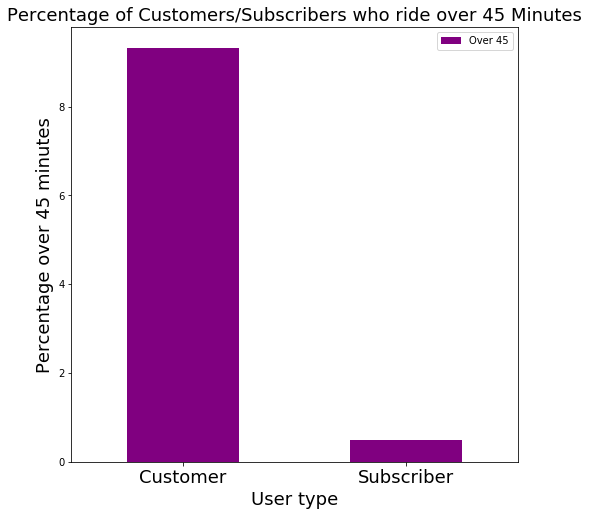

In [8]:
# Set up figures
fig = pl.figure(figsize(8,8))

# plot charts
finaldf[["Over 45"]].plot(kind="bar", color=['Purple'])

# Format Charts
pl.title('Percentage of Customers/Subscribers who ride over 45 Minutes', 
         fontsize = 18)
pl.xlabel('User type', fontsize = 18)
pl.ylabel('Percentage over 45 minutes', fontsize = 18)
pl.xticks([0,1],["Customer","Subscriber"], fontsize = 18,rotation='horizontal')
pl.legend();


## Figure 1: Percentage Customers and Subscribers who ride over 45 minutes 

### Note: The percentage of trips that subscribers travel for over 45 minutes is small in comparison to the Customers. Let's assess if this is statistically different.

### Is the percentage of Customers that travel for more than 45 minutes greater than or equal to that of the percentage of Subscribers
## The statistics is: 
# $z = \frac{(p_0 - p_1)}{SE} $
# $p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$
# $SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$
## and in this notation 
# $p_0 = \frac{S_{\mathrm{Over 45}}}{S_{\mathrm{Total}}}$
### and 
# $p_1 = \frac{C_{\mathrm{Over 45}}}{C_{\mathrm{Total}}}$


In [9]:
P0 = finaldf[["Over 45"]].loc["Subscriber"][0]/100
P1 = finaldf[["Over 45"]].loc["Customer"][0]/100
P0, P1

(0.0048664691493236281, 0.093279222775625656)

In [10]:
CitiBikeCounts = CitibikeData.groupby('User Type')['Over45'].value_counts().unstack(level=-1).stack(dropna=False).reset_index(name="Count")
CitiBikeCountsOver45 = CitiBikeCounts.loc[CitiBikeCounts['Over45'] == 'Over 45']

CitiBikeCountsOver45

,User Type,Over45,Count
0,Customer,Over 45,3034
2,Subscriber,Over 45,3768


In [11]:
n0 = int(CitiBikeCountsOver45.loc[CitiBikeCountsOver45['User Type'] == 'Subscriber']["Count"])
n1 = int(CitiBikeCountsOver45.loc[CitiBikeCountsOver45['User Type'] == 'Customer']["Count"])
n0, n1

(3768, 3034)

In [12]:
P0mP1 = P0 - P1
print ("Difference between Subscribers who ride over 45 mins and Customers who ride over 45 mins is: ", P0mP1)
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

Difference between Subscribers who ride over 45 mins and Customers who ride over 45 mins is:  -0.0884127536263
In accordance with Null Hypothesis


### Is this difference statistically significant?

In [13]:
Pcomb = round(float((P0 * n0 + P1 * n1) / (n0 + n1)),6)
SEp = round(float(np.sqrt(Pcomb * (1 - Pcomb) * ( (1. / n0) + (1. / n1)))),6)
zStat = (P0mP1 - 0) / SEp
Pcomb, SEp, zStat

(0.044303, 0.005019, -17.615611401933059)

In [14]:
pVal = scipy.stats.norm.pdf(zStat)
print ("The z statistic is {:.2f} and corresponding p-value is {:.4e}.".format(zStat,pVal))



The z statistic is -17.62 and corresponding p-value is 1.6520e-68.


#### The   p value is a lot smaller than our chosen $\alpha=0.05$ - so yes, the result is statistically significant (by a lot!)

# We reject the Null Hypothesis, and conclude that the proportion of Subscribers who ride for greater than 45 minutes is higher than the proportion of Customers who ride for greater than 45 minutes.   $p< 0.05$

# Chi-squared test


* Contingency table populated with ridership type and trip over and under 45 mins*

|Citibike ridership     |     Over 45   | Under 45        |     Total              
|---------------------------|-----------|-----------|----------------|
| Customer               |   3034        |      29492     |        32526        |
| Subscriber             |     3768      |      770510     |     774278           |
|                           |           |           |                |
| Total                     |      6802    |   800002       |        806804       |

In [18]:
CitiBikeSumm.pivot(index='User Type', columns='Over45', 
                   values='Count')

Over45,Over 45,Under 45
User Type,,
Customer,3034,29492
Subscriber,3768,770510


In [22]:
3768 +770510 + 3034 + 29492

806804

In [21]:
  3034        +     29492 

32526